In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
# import cv2
import matplotlib.pyplot as plt
from PIL import Image
import datetime

import copy
from scipy import ndimage
import torchvision.transforms as transforms

# Loading images & Preprocessing

In [2]:
PATH = Path('./data/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def image_loader(image_name):
    image = Image.open(image_name)
    r, c = image.size
    l = r if r<c else c
    box = (r/2-l/2, c/2-l/2, r/2+l/2, c/2+l/2)
    image = image.crop(box)
    loader = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


unloader = transforms.ToPILImage()  

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [4]:
style_img = image_loader("./data/style/candy.jpg")
content_img = image_loader("./data/content/flowers.jpg")

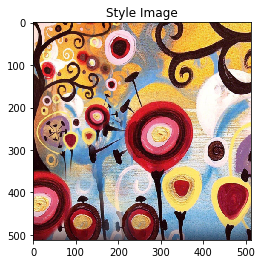

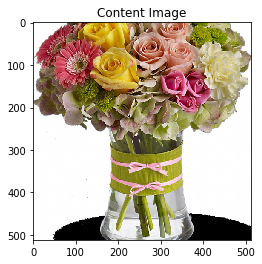

In [5]:
plt.ion()

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [81]:
def saveimg(imgname, filename):
    image = imgname.cpu().clone()  
    image = image.squeeze(0)
    image = unloader(image)
    figure = plt.figure()
    plt.imshow(image)
    figure.savefig(filename)

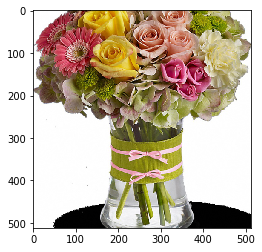

In [83]:
saveimg(content_img, './data/output/v3_content_img.jpg')

# Model

In [6]:
cnn = models.vgg19(pretrained=True).cuda().eval()

In [7]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).cuda()
        self.std = torch.tensor(std).view(-1, 1, 1).cuda()

    def forward(self, img):
        return (img - self.mean) / self.std

In [8]:
normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)
model = nn.Sequential(normalization)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## content&style optimization

In [9]:
content_layers = ['20']
style_layers = ['1', '6', '11', '20', '29']

In [10]:
layers = list(cnn.children())[0][:20]

content_cnn = nn.Sequential(normalization)
for i, l in enumerate(layers):
    content_cnn.add_module('{}'.format(i+1), l)

In [48]:
class StyleCnn(nn.Module):
    def __init__(self):
        super(StyleCnn, self).__init__()
        self.select = ['1', '6', '11', '20', '29']
        self.cnn = models.vgg19(True).features
        for param in self.cnn.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = []
        for name, layer in self.cnn._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [49]:
# style_cnn_initial = StyleCnn()
# style_cnn = nn.Sequential(normalization)
# for i, l in enumerate(list(style_cnn_initial.children())[0]):
#     style_cnn.add_module('{}'.format(i+1), l)

style_cnn = StyleCnn()

In [13]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  
    return G.div(a * b * c * d)

In [14]:
# class ContentLoss(nn.Module):
#     def __init__(self, target):
#         super(ContentLoss, self).__init__()
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input


# class StyleLoss(nn.Module):
#     def __init__(self, target_feature):
#         super(StyleLoss, self ).__init__()
#         self.target = gram_matrix(target_feature).detach()
#     def forward(self, input):
#         G = gram_matrix(input)
#         self.loss = F.mse_loss(G, self.target)
#         return input

### training content

In [15]:
input_img = torch.randn(content_img.data.size())

In [16]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = im.cpu().numpy()[0]
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [29]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()


def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=torch.Size([512, 512, 3])).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.Adam([im_opt], lr=0.01)
    return im_opt, optimizer


def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
        loss = F.mse_loss(content_cnn(im_opt), targ_v.detach())
        loss.backward()
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [18]:
targ_v = content_cnn(content_img)

In [19]:
im_opt, optimizer = get_input(lr=0.01)

In [20]:
start_time = datetime.datetime.now()
im_opt = train_image(optimizer, targ_v, im_opt, 2000)
print(f"Training time: {datetime.datetime.now()-start_time}.")

215.70657348632812
6.5433030128479
3.097966194152832
1.9063526391983032
1.335782527923584
1.0133249759674072
0.8040151596069336
0.6680623888969421
0.557780385017395
0.48699048161506653
Training time: 0:08:20.187360.


In [26]:
content_opt = im_opt.cpu().detach().numpy()
content_opt = np.rollaxis(content_opt[0],0,3)

In [86]:
content_opt.shape

(512, 512, 3)

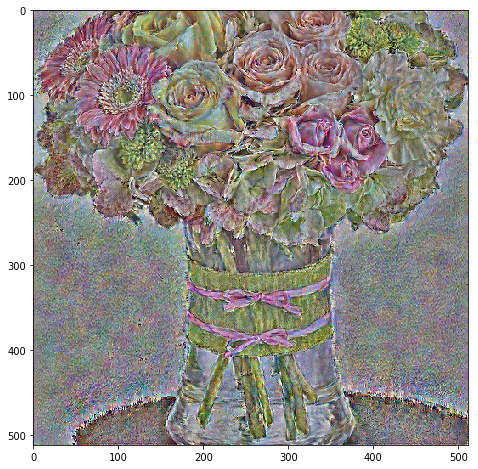

In [27]:
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(content_opt)

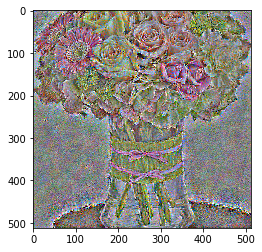

In [87]:
fig_content = plt.figure()
plt.imshow(content_opt)
fig_content.savefig('./data/output/v3_content_noise.jpg')

### training style

In [28]:
# def get_input(lr=0.01):
#     opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
#     opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
#     im_opt = transform_images(opt_img)
#     im_opt.requires_grad=True
#     optimizer = optim.Adam([im_opt], lr=0.01)
#     return im_opt, optimizer

In [57]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
            # run the model
        out = style_cnn(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
        loss = sum(losses)
        loss.backward()     
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    return im_opt

In [61]:
style_cnn = style_cnn.cuda().eval()
im_style_f = style_cnn(style_img)
opt_img, optimizer = get_input(lr=0.1)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

start_time = datetime.datetime.now()
im_opt = train_style(optimizer, targ_g, opt_img, 2000)
print(f"Training time: {datetime.datetime.now()-start_time}.")

3.7700894608860835e-05
4.375124262878671e-06
2.082977061945712e-06
1.4259843510444625e-06
1.1157242170156678e-06
9.34364834392909e-07
8.149899031195673e-07
7.292704253814009e-07
6.643741130574199e-07
6.136656907074212e-07
Training time: 0:10:41.587350.


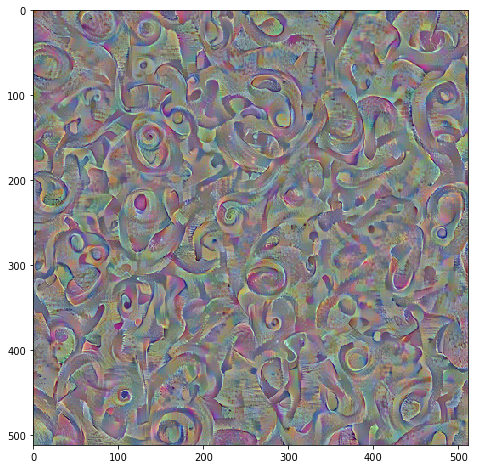

In [62]:
style_opt = im_opt.cpu().detach().numpy()
style_opt = np.rollaxis(style_opt[0],0,3)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(style_opt)

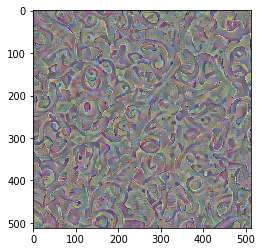

In [89]:
fig_style = plt.figure()
plt.imshow(style_opt)
fig_style.savefig('./data/output/v3_style_noise.jpg')

### style transfer

In [64]:
im_opt, optimizer = get_input(lr=0.1)

In [63]:
content_target = content_cnn(content_img).detach()

im_style_f = style_cnn(style_img)
style_target = [gram_matrix(f).detach() for f in im_style_f]

In [67]:
def train_all(optimizer, im_opt, content_target, style_target, iters):
    for i in range(iters):
        optimizer.zero_grad()
        out = style_cnn(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t) for o,t in zip(input_g, style_target)]
        loss = 100000*sum(losses)
        loss += F.mse_loss(content_cnn(im_opt), content_target)/10
        loss.backward()     
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    return im_opt

In [68]:
start_time = datetime.datetime.now()
im_opt = train_all(optimizer, im_opt, content_target, style_target, 2000)
print(f"Training time: {datetime.datetime.now()-start_time}.")

25.145540237426758
1.197160005569458
0.6979735493659973
0.5035401582717896
0.4015958905220032
0.3370698094367981
0.29290664196014404
0.26064532995224
0.23628729581832886
0.21937163174152374
Training time: 0:20:09.510928.


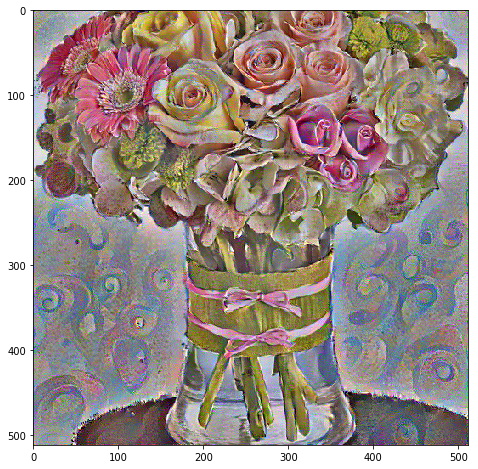

In [69]:
final_opt = im_opt.cpu().detach().numpy()
final_opt = np.rollaxis(final_opt[0],0,3)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(final_opt)

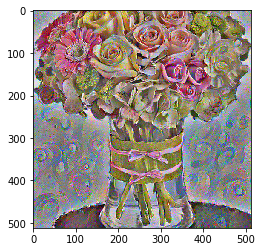

In [90]:
fig_final = plt.figure()
plt.imshow(final_opt)
fig_final.savefig('./data/output/v3_final.jpg')